In [1]:
import os
import torch
import matplotlib.pyplot as plt

In [2]:
data_dir = "."
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))
pred_dset = torch.load(os.path.join(data_dir,'pred.dset'))

# note that resolution is doubled due to downsampling data by a factor of 2
resolution = 2 * 11.1732 * 1e-6
bins_x = torch.arange(-100,100) * resolution

In [3]:
from fitting_methods import fit_gaussian_linear_background
import numpy as np

def fit_image(img, visualize=False, n_fitting_restarts=50):
    x_projection = np.sum(img, axis=0)
    y_projection = np.sum(img, axis=1)

    # subtract min value from projections
    x_projection = x_projection - x_projection[:10].min()
    y_projection = y_projection - y_projection[:10].min()

    para_x = fit_gaussian_linear_background(
        x_projection, visualize=visualize, n_restarts=n_fitting_restarts
    )
    para_y = fit_gaussian_linear_background(
        y_projection, visualize=visualize, n_restarts=n_fitting_restarts
    )

    return {
        "centroid": np.array((para_x[1], para_y[1])),
        "rms_sizes": np.array((para_x[2], para_y[2])),
        "total_intensity": img.sum(),
        "log10_total_intensity": np.log10(img.sum()),
    }

In [4]:
import pandas as pd


data = []
for ele in [train_dset, test_dset, pred_dset]:
    k = ele.k.flatten(end_dim=-2)
    images = ele.images.flatten(end_dim=-3) 
    
    results = []
    for i,img in enumerate(images):
        res = fit_image(img.numpy()) | {"k":float(k[i])}
        res = res | {"Sx": res["rms_sizes"][0]*resolution,"Sy": res["rms_sizes"][1]*resolution}
        results += [res]
        
    data += [pd.DataFrame(results)]  

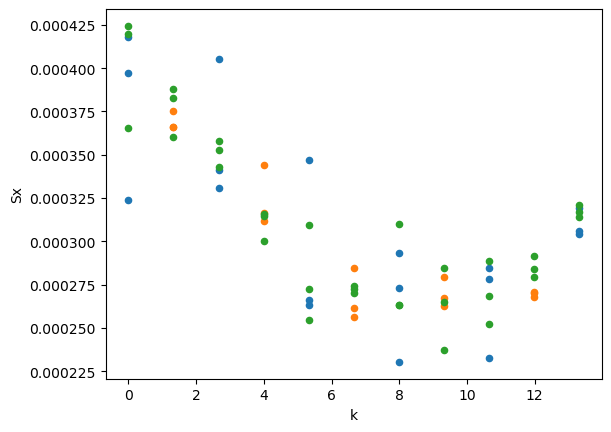

In [5]:
fig,ax = plt.subplots()

for i, ele in enumerate(data):
    ele.plot.scatter(x="k",y="Sx",ax=ax,c=f"C{i}")


In [6]:
from emitopt.analysis import compute_emit_bayesian, compute_emit_bmag, normalize_emittance
from emitopt.beam_dynamics import reconstruct_beam_matrix

In [7]:

l_drift = 2.7016
rmat = torch.tensor((
    (1.0, l_drift), 
    (0.0, 1.0)
))

for ele in data:
    xemit_results = compute_emit_bmag(
        -torch.tensor(ele["k"].to_numpy()) + 0.0001,
        (torch.tensor(ele["Sx"].to_numpy())*1e3)**2, # do everythin in mm
        0.108,
        rmat,
        thick=False
    )
    print(normalize_emittance(xemit_results[0], 0.125))
    
    yemit_results = compute_emit_bmag(
        torch.tensor(ele["k"].to_numpy()) + 0.0001,
        (torch.tensor(ele["Sy"].to_numpy())*1e3)**2,
        0.108,
        rmat,
        thick=False,
    )
    print(normalize_emittance(yemit_results[0], 0.125))

tensor(2.6081, dtype=torch.float64)
tensor(5.3734, dtype=torch.float64)
tensor(2.5356, dtype=torch.float64)
tensor(4.7903, dtype=torch.float64)
tensor(2.9503, dtype=torch.float64)
tensor(4.8307, dtype=torch.float64)
